<a href="https://colab.research.google.com/github/JulianSchmidtke/CAPTUM/blob/main/AsuD_CAPTUM_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!git clone https://github.com/JulianSchmidtke/CAPTUM.git

Cloning into 'CAPTUM'...
remote: Enumerating objects: 478, done.
remote: Counting objects: 100% (478/478), done.
remote: Compressing objects: 100% (455/455), done.
remote: Total 478 (delta 23), reused 463 (delta 20), pack-reused 0
Receiving objects: 100% (478/478), 5.19 MiB | 13.22 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk, os
import pandas as pd
import numpy as np

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
#Arbeitsverzeichnis auf das Ordnerverzeichnis ändern, in welchem die Daten liegen (txt-Format)

cwd = os.getcwd()
nwd = r'/content/CAPTUM/files'

os.chdir(nwd)

#Speichern der Dateinamen in einem Array
files = os.listdir()

In [71]:
#Zu Testzwecken werden lediglich die letzten 5 Dateien verwendet
files = files[100:201]

In [72]:
fileNameTags = list(map(lambda fn: fn.split('_')[0:-2],files))

fileName = [fNT[-1] for fNT in fileNameTags]
fileTags = [fNT[1:-1] for fNT in fileNameTags]
fileYear = [fY[-8:-4] for fY in fileName]

print(fileNameTags)
print(fileName)
print(fileTags)
print(fileYear)

[['CAPTUM', 'D-Dimer', 'Duration', 'Kolkhir 2017.pdf'], ['CAPTUM', 'Total IgE', 'TPO', 'Demirkan 2019.pdf'], ['CAPTUM', 'ASST\uf028', 'serverity\uf028', 'Aktar 2015.pdf'], ['CAPTUM', 'ASST\uf028', 'Total IgE', 'Gao 2020 .pdf'], ['CAPTUM', 'Duration', 'Angioedema', 'Abolnezhadian 2016.pdf'], ['CAPTUM', 'Duration', 'Angioedema', 'Cavkaytar 2015.pdf'], ['CAPTUM', 'Severity', 'Antihistamine', 'Hofman 2020.pdf'], ['CAPTUM', 'TPO', 'Thyroglobulin', 'Mozena 2010.pdf'], ['CAPTUM', 'CRP', 'Angioedema', 'Ghazanfar 2018.pdf'], ['CAPTUM', 'Basophil', 'Antihistamine', '~Irinyi 2007.pdf'], ['CAPTUM', 'CRP', 'Severity', 'Grzanka 2014.pdf'], ['CAPTUM', 'Duration', 'Omalizumab', 'Su 2020.pdf'], ['CAPTUM', 'BAT', 'Severity', 'Schoepke 2019.pdf'], ['CAPTUM', 'Severity', 'Duration', 'Nettis 2006.pdf'], ['CAPTUM', 'Total IgE', 'Eosinophil', 'Park 2013.pdf'], ['CAPTUM', 'BHRA', 'Basophil', 'Grattan 2000.pdf'], ['CAPTUM', 'BAT', 'Basophil', 'Sanchez 2019.pdf'], ['CAPTUM', 'Severity', 'Angioedema', 'Sussman 2

In [73]:
#Einen leeren Pandas-Dataframe erstellen

df = pd.DataFrame(index=files)
print(df)

Empty DataFrame
Columns: []
Index: [CAPTUM_D-Dimer_Duration_Kolkhir 2017.pdf_out_text.txt, CAPTUM_Total IgE_TPO_Demirkan 2019.pdf_out_text.txt, CAPTUM_ASST_serverity_Aktar 2015.pdf_out_text.txt, CAPTUM_ASST_Total IgE_Gao 2020 .pdf_out_text.txt, CAPTUM_Duration_Angioedema_Abolnezhadian 2016.pdf_out_text.txt, CAPTUM_Duration_Angioedema_Cavkaytar 2015.pdf_out_text.txt, CAPTUM_Severity_Antihistamine_Hofman 2020.pdf_out_text.txt, CAPTUM_TPO_Thyroglobulin_Mozena 2010.pdf_out_text.txt, CAPTUM_CRP_Angioedema_Ghazanfar 2018.pdf_out_text.txt, CAPTUM_Basophil_Antihistamine_~Irinyi 2007.pdf_out_text.txt, CAPTUM_CRP_Severity_Grzanka 2014.pdf_out_text.txt, CAPTUM_Duration_Omalizumab_Su 2020.pdf_out_text.txt, CAPTUM_BAT_Severity_Schoepke 2019.pdf_out_text.txt, CAPTUM_Severity_Duration_Nettis 2006.pdf_out_text.txt, CAPTUM_Total IgE_Eosinophil_Park 2013.pdf_out_text.txt, CAPTUM_BHRA_Basophil_Grattan 2000.pdf_out_text.txt, CAPTUM_BAT_Basophil_Sanchez 2019.pdf_out_text.txt, CAPTUM_Severity_Angioedema_

In [74]:
c = []
for file in files:
    f = open(file, "r", encoding = "ISO-8859-1")
    c.append(f.read())
    f.close

In [75]:
df['Name'] = fileName
df['Tags'] = fileTags
df['Year'] = fileYear
df['Content'] = c
df

,Name,Tags,Year,Content
CAPTUM_D-Dimer_Duration_Kolkhir 2017.pdf_out_text.txt,Kolkhir 2017.pdf,"[D-Dimer, Duration]",2017,DR. SABINE ALTRICHTER (Orcid ID : O000-0001-99...
CAPTUM_Total IgE_TPO_Demirkan 2019.pdf_out_text.txt,Demirkan 2019.pdf,"[Total IgE, TPO]",2019,Original paper\n\nRationale for the autologous...
CAPTUM_ASST_serverity_Aktar 2015.pdf_out_text.txt,Aktar 2015.pdf,"[ASST, serverity]",2015,Original paper\n\nThe relation of autologous s...
CAPTUM_ASST_Total IgE_Gao 2020 .pdf_out_text.txt,Gao 2020 .pdf,"[ASST, Total IgE]",020,Am J Trans! Res 2020;12(8):4434-4444\nwww.ajtr...
CAPTUM_Duration_Angioedema_Abolnezhadian 2016.pdf_out_text.txt,Abolnezhadian 2016.pdf,"[Duration, Angioedema]",2016,BREIF COMMUNICATION\nIran J Allergy Asthma Imm...
...,...,...,...,...
CAPTUM_Total IgE_Antihistamine_Türk 2020.pdf_out_text.txt,Türk 2020.pdf,"[Total IgE, Antihistamine]",2020,Title: Effectiveness of as-needed antihistamin...
CAPTUM_CRP_D-Dimer_Montjoye 2020.pdf_out_text.txt,Montjoye 2020.pdf,"[CRP, D-Dimer]",2020,"Correlations between disease activity, autoimm..."
CAPTUM_Basophil_Allergic Diseases_Vasagar 2006.pdf_out_text.txt,Vasagar 2006.pdf,"[Basophil, Allergic Diseases]",2006,"Clinical and Experimental Allergy, 36, 770-776..."
CAPTUM_Basophil_Antihistamine_Dyke 2008.pdf_out_text.txt,Dyke 2008.pdf,"[Basophil, Antihistamine]",2008,doi: 10.1111/).1365-2222.2007.02864.x\n\n \n\n...


In [76]:
stop_words=set(stopwords.words("english"))
def stoppingFunc(text, stop_words=stop_words):
    filtered_text=[]
    for word in text:
        if len(word) < 3:
            next
        elif sum(c.isdigit() for c in word)>0:
            next
        elif word not in stop_words:
            filtered_text.append(word)
        
    return filtered_text

In [77]:
def stemmingFunc(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text]

In [78]:
def lemmatizingFunc(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [79]:
df['Content'] = df['Content'].apply(lambda text: nltk.word_tokenize(text))
df['Content'] = df['Content'].apply(stoppingFunc)
df['Content'] = df['Content'].apply(stemmingFunc)
df['Content'] = df['Content'].apply(lemmatizingFunc)
df['Corpus'] = [' '.join(x) for x in df['Content']]

In [80]:
df

,Name,Tags,Year,Content,Corpus
CAPTUM_D-Dimer_Duration_Kolkhir 2017.pdf_out_text.txt,Kolkhir 2017.pdf,"[D-Dimer, Duration]",2017,"[dr., sabin, altricht, orcid, prof., marcu, ma...",dr. sabin altricht orcid prof. marcu maurer or...
CAPTUM_Total IgE_TPO_Demirkan 2019.pdf_out_text.txt,Demirkan 2019.pdf,"[Total IgE, TPO]",2019,"[origin, paper, rational, autolog, serum, skin...",origin paper rational autolog serum skin test ...
CAPTUM_ASST_serverity_Aktar 2015.pdf_out_text.txt,Aktar 2015.pdf,"[ASST, serverity]",2015,"[origin, paper, the, relat, autolog, serum, pl...",origin paper the relat autolog serum plasma sk...
CAPTUM_ASST_Total IgE_Gao 2020 .pdf_out_text.txt,Gao 2020 .pdf,"[ASST, Total IgE]",020,"[tran, re, www.ajtrorg, origin, articl, pathog...",tran re www.ajtrorg origin articl pathogen rol...
CAPTUM_Duration_Angioedema_Abolnezhadian 2016.pdf_out_text.txt,Abolnezhadian 2016.pdf,"[Duration, Angioedema]",2016,"[breif, commun, iran, allergi, asthma, immunol...",breif commun iran allergi asthma immunol augus...
...,...,...,...,...,...
CAPTUM_Total IgE_Antihistamine_Türk 2020.pdf_out_text.txt,Türk 2020.pdf,"[Total IgE, Antihistamine]",2020,"[titl, effect, as-need, antihistamin, chronic,...",titl effect as-need antihistamin chronic spont...
CAPTUM_CRP_D-Dimer_Montjoye 2020.pdf_out_text.txt,Montjoye 2020.pdf,"[CRP, D-Dimer]",2020,"[correl, diseas, activ, autoimmun, biolog, par...",correl diseas activ autoimmun biolog paramet p...
CAPTUM_Basophil_Allergic Diseases_Vasagar 2006.pdf_out_text.txt,Vasagar 2006.pdf,"[Basophil, Allergic Diseases]",2006,"[clinic, experiment, allergi, origin, paper, b...",clinic experiment allergi origin paper blackwe...
CAPTUM_Basophil_Antihistamine_Dyke 2008.pdf_out_text.txt,Dyke 2008.pdf,"[Basophil, Antihistamine]",2008,"[doi, rigin, paper, clinic, experiment, allerg...",doi rigin paper clinic experiment allergi the ...


In [81]:
print('Tags:')
tags = {element for e in df['Tags'] for element in e}
print(*tags, sep="\n")

Tags:
Duration
TPO
anti-FcεRI
Omalizumab
Basophil
Anti-IgE
angioedema
D-Dimer
Total IgE
Antihistamine
Thyroglobulin
BHRA
IL-24
Angioedema
anti-TPO IgE ratio
ASST
BAT
CRP
Allergic Diseases
serverity
ANA
duration
Severity
Eosinophil
omalizumab


# Algorithmen anwenden

### TFIDF Vertorizer

In [82]:
tfidfconvert = TfidfVectorizer(ngram_range=(1,3)).fit(df.Corpus.values)

In [83]:
len(tfidfconvert.vocabulary_)

327937

In [84]:
words_transformed = tfidfconvert.transform(df.Corpus.values)

### K-Means Clustering

In [85]:
from sklearn.cluster import KMeans

K-Means für mehrere k's berechnen

In [91]:
Sum_of_squared_distances = []
max_range = 10
K = range(1,max_range + 1)
for k in K: 
    print(str(k) + "/" + str(max_range))
    km = KMeans(n_clusters=k)
    km = km.fit(words_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


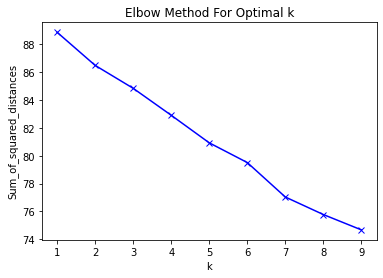

In [92]:
plt.plot(K,Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()